<a href="https://colab.research.google.com/github/mingzheshao/Walmart-Prediction/blob/main/MingzheShao_Walmart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction

## 1.1 Goal:
We have been challenged to predict sales data provided by the retail giant Walmart 28 days into the future. This competition will run in 2 tracks: In addition to forecasting the values themselves in the Forecasting competition, we are simultaneously tasked to estimate the uncertainty of our predictions in the Uncertainty Distribution competition. Both competitions will have the same 28 day forecast horizon.

## 1.2 Data:
We are working with 42,840 hierarchical time series. The data were obtained in the 3 US states of California (CA), Texas (TX), and Wisconsin (WI). “Hierarchical” here means that data can be aggregated on different levels: item level, department level, product category level, and state level. The sales information reaches back from Jan 2011 to June 2016. In addition to the sales numbers, we are also given corresponding data on prices, promotions, and holidays. Note, that we have been warned that most of the time series contain zero values.

The data comprises 3049 individual products from 3 categories and 7 departments, sold in 10 stores in 3 states. The hierachical aggregation captures the combinations of these factors. For instance, we can create 1 time series for all sales, 3 time series for all sales per state, and so on. The largest category is sales of all individual 3049 products per 10 stores for 30490 time series.

The training data comes in the shape of 3 separate files:

*   sales_train.csv: this is our main training data. It has 1 column for each of the 1941 days from 2011-01-29 and 2016-05-22; not including the validation period of 28 days until 2016-06-19. It also includes the IDs for item, department, category, store, and state. The number of rows is 30490 for all combinations of 30490 items and 10 stores.
*   sell_prices.csv: the store and item IDs together with the sales price of the item as a weekly average.
*   calendar.csv: dates together with related features like day-of-the week, month, year, and an 3 binary flags for whether the stores in each state allowed purchases with SNAP food stamps at this date (1) or not (0).

## 1.3 Evaluation Metrics:


*   The point forecast submission are being evaluated using the Root Mean Squared Scaled Error (RMSSE), which is derived from the Mean Absolute Scaled Error (MASE) that was designed to be scale invariant and symmetric. In a similar way to the MASE, the RMSSE is scale invariant and symmetric, and measures the prediction error (i.e. forecast - truth) relative to a “naive forecast” that simply assumes that step i = step i-1. In contrast to the MASE, here both prediction error and naive error are scaled to account for the goal of estimating average values in the presence of many zeros.
*   The uncertainy distributions are being evaluated using the Weighted Scaled Pinball Loss (WSPL). We are asked to provide the 50%, 67%, 95%, and 99% uncertainty intervals together with the forecasted median.
*   Both metrics are computed for each time series and then averaged accross all time series including weights. The weights are proportional to the sales volume of the item, in dollars, to give more importance to high selling products. Note, that the weights are based on the last 28 days of the training data, and that those dates will be adjusted for the ultimate evaluation data, as confirmed by the organisers.

# 2. Preparation

## 2.1 Import Packages

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import plotly.graph_objects as go
import plotly.express as px
!pip install jupyter-dash
from jupyter_dash import JupyterDash
from dash import Dash, dcc, html, callback, Output, Input
!pip install moepy
from moepy import lowess
!pip install matplotlib==3.1.3
import matplotlib.pyplot as plt
import math
from plotly.subplots import make_subplots
import lightgbm as lgbm
import gc
import joblib
import os

## 2.2 Load Data

In [ ]:
# mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')
# load data
train = pd.read_csv('/content/drive/MyDrive/m5-forecasting-accuracy/sales_train_validation.csv')
prices = pd.read_csv('/content/drive/MyDrive/m5-forecasting-accuracy/sell_prices.csv')
calendar = pd.read_csv('/content/drive/MyDrive/m5-forecasting-accuracy/calendar.csv')
sample_submit = pd.read_csv('/content/drive/MyDrive/m5-forecasting-accuracy/sample_submission.csv')

# 3. Exploratary Data Analysis

### 3.1 Quick Look: Dataset structure and content

#### 3.1.1 Sales Training Dataset

In [ ]:
train.head(5)

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  
1       1       0       0       0       0  
2       1       0       1       1       1  
3       0       1       3       7       2  
4       1       2       2       2       4  

[5 rows x 1919 columns]

**Findings**:
1. The general ID is a combination of item ID, department ID, category ID, store ID.
2. The sales per day from Day1 to Day1908 are presented as columns, with the prefix `d_`. These are the number of units sold instead of the amount of dollars.
3. We can already see the dataset is very sparse, which means there are a lot of zeros.

#### 3.1.2 Sell Prices Dataset

In [ ]:
prices.head(5)

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [ ]:
prices.describe()

wm_yr_wk    sell_price
count  6.841121e+06  6.841121e+06
mean   1.138294e+04  4.410952e+00
std    1.486100e+02  3.408814e+00
min    1.110100e+04  1.000000e-02
25%    1.124700e+04  2.180000e+00
50%    1.141100e+04  3.470000e+00
75%    1.151700e+04  5.840000e+00
max    1.162100e+04  1.073200e+02

**Findings**:
1. **store_id** and **item_id** can be used as keys linking to the training dataset.
2. The sale prices ranges from \$0.1 to \$107.
3. The price of each item in each store changes weekly. **wm_yr_wk** indicates the year and the week of the year.

#### 3.1.3 Calendar

In [ ]:
calendar.head(5)

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

#### 3.1.4 Missing Values & Zeros

In [ ]:
# Count missing values
train.isna().sum().sum()

0

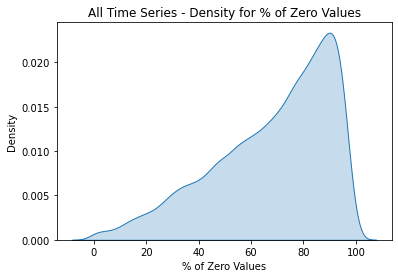

In [ ]:
#@title
zero_perc = 100*(train == 0).sum(axis=1)/len(train.columns)
sns.kdeplot(zero_perc.values,fill=True)
plt.xlabel('% of Zero Values')
plt.title('All Time Series - Density for % of Zero Values')
plt.show()

**Findings**:
1. There are no missing values in our training time series data.
2. However, we get a lot of zeros. The majority of time series have over 50% of zero values.

## 3.2 Overview: Time Series Plots

### 3.2.1 Individual Item-Level TS (Random Sample)

In [ ]:
#@title
def random_ts(df, rand = True):
  start_dt = datetime.strptime('2011-01-29','%Y-%m-%d')
  rand_df = df.copy()
  rand_df.columns = [(start_dt+timedelta(days=int(i[2:])-1)).date() if i[:2]=='d_' else i for i in rand_df.columns]
  rand_df['cols'] = sns.color_palette('pastel',n_colors=len(rand_df))
  # rand_df = rand_df.drop(['item_id','dept_id','cat_id','store_id','state_id'],axis=1)
  rand_df['id'] = rand_df['id'].map(lambda x: x.replace('_validation',''))
  if rand == True:
    rand_df = rand_df.sample(50,axis=0,random_state=1)
  return rand_df

In [ ]:
#@title
random_train = random_ts(train)
app = JupyterDash(__name__)
app.layout = html.Div([
    "Sales over time -- Select a time series ID:",
    dcc.Dropdown(random_train['id'], 'FOODS_3_183_CA_3', multi=False, id='my-dropdown'),
    dcc.Graph(id='my-graph')
])
@callback(
    Output('my-graph', 'figure'),
    Input('my-dropdown', 'value')
)
def update_graph(label_selected):
  dff = random_train[random_train['id']==label_selected].set_index('id')
  fig = px.line(dff.iloc[0,:],labels={'index':'Date','value':'Daily Sales'})
  fig.update_traces(line_color='rgb'+str((dff['cols'].values[0])))
  return fig
app.run_server(mode='inline',debug=True)

<IPython.core.display.Javascript object>

**Findings**:
1. Most of the time series have low daily unit sale counts and some a large portion of days have zero sales. At the same time, this also suggests that spikes should not be overly explained but also indicates we have to deal with a lot of noise for the forecasting.
2. Some time series only begin to have daily sales from the middle, which means that some products were not launched at the beginning, and some have long gaps in between. These causes challenges for the forecasting as well.

### 3.2.2 Aggregated Whole Sales

In [ ]:
df = random_ts(train, rand = False)
fig = px.line(df.sum(), labels={'index':'Date','value':'Sales'})
fig.update_layout(showlegend=False,title='Aggregated Whole Sales')

**Findings:**
1. The general trend for the sales are going up, which is a good sign. And we can notice some yearly seasonality here with a peak in the middle of the year and a dip at **Chistmas**, which is the only day of the whole year when the stores are closed.
2. The recent 2016 sales volume increases a bit faster than previous yeara.
3. Zooming in, shorter period patterns can be identified, like weekly seasonality.

### 3.2.3 Monthly Sales per State

In [ ]:
#@title
df_state = df.groupby('state_id').sum()
df_state = df_state.T
df_state['ym'] = df_state.index.map(lambda x: str(x)[:7])
# Ignore the first month(2011-01) and the last month(2016-04) since the data doesn't include the sales of the whole month
fig = px.line(df_state.groupby('ym').sum().iloc[1:63,:], labels={'ym':'Date','value':'Sales'})
fig.update_layout(title='Monthly Sales per State')

**Findings:**
1. In general, CA sells more while WI is slowly catching up to TX and, at the end of the time range we observe, it surpassed TX. 
2. CA has pronounced peaks and dips in 2012 to 2015 that also appear in other states as well, but CA's are more severe. Although 2012 doesn't have a significant dip, generally these peaks and dips may reflect the yearly seasonality we've already noticed.

### 3.2.4 Monthly Sales per Store

Text(0.5, 0.98, 'Monthly Sales per Store')

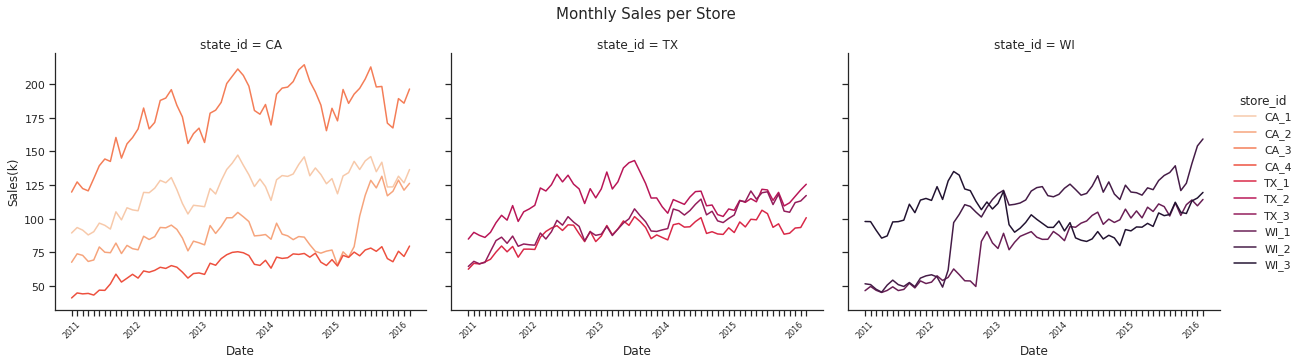

In [ ]:
#@title
df_store = df.groupby(['state_id','store_id']).sum().T
df_store['ym'] = df_store.index.map(lambda x: str(x)[:7])
df_store = df_store.groupby('ym').sum().iloc[1:63,:]/1000
import seaborn as sns
sns.set_theme(style="ticks")
# Define the palette as a list to specify exact values
palette = sns.color_palette("rocket_r",10)
# Plot the lines on three facets
g = sns.relplot(
    data=pd.DataFrame(df_store.T.to_records()).melt(id_vars=['state_id','store_id'],var_name='ym'),
    x="ym", y="value",
    hue="store_id", col="state_id",
    kind="line", palette=palette,
    height=5, aspect=1.15, facet_kws=dict(sharex=True),
)
xticks = [2011]+['']*10+[2012]+['']*11+[2013]+['']*11+[2014]+['']*11+[2015]+['']*11+[2016]+['']*2
for ax in g.axes.flat:
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales(k)')
    ax.set_xticklabels(xticks,fontsize=8, rotation=45)
g.fig.subplots_adjust(top=0.85) 
g.fig.suptitle('Monthly Sales per Store',size=15)

**Findings:**
1. CA stores are relatively well separated in store volume. 'CA_3' has the most sales volume. Noteworthy, 'CA_2' decreased to the level of 'CA_4' in year 2015 and jumped up to the 'CA_1' level in the next year.
2. TX stores are quite close together in sales.'TX_3' is catching up to 'TX_2' from the 'TX_1' level over time of our training data. 
3. 'WI_1' and 'WI_2' show a suddent jump in year 2012 while 'WI_3' experienced a long dip over time.

### 3.2.5 Monthly Sales per Category

In [ ]:
#@title
df_cat = df.groupby('cat_id').sum()
df_cat = df_cat.T
df_cat['ym'] = df_cat.index.map(lambda x: str(x)[:7])
# Ignore the first month(2011-01) and the last month(2016-04) since the data doesn't include the sales of the whole month
fig = px.line(df_cat.groupby('ym').sum().iloc[1:63,:], labels={'ym':'Date','value':'Sales'})
fig.update_layout(title='Monthly Sales per Category')

**Findings:**
1. The category **FOODS** has the highest sales, followed by **HOUSEHOLD**. We can see These two category experience a slow uplift over the year while **HOBBIES** doesn't change progressively.

### 3.2.6 Monthly Sales per Department and State

Text(0.5, 0.98, 'Monthly Sales per Department and State')

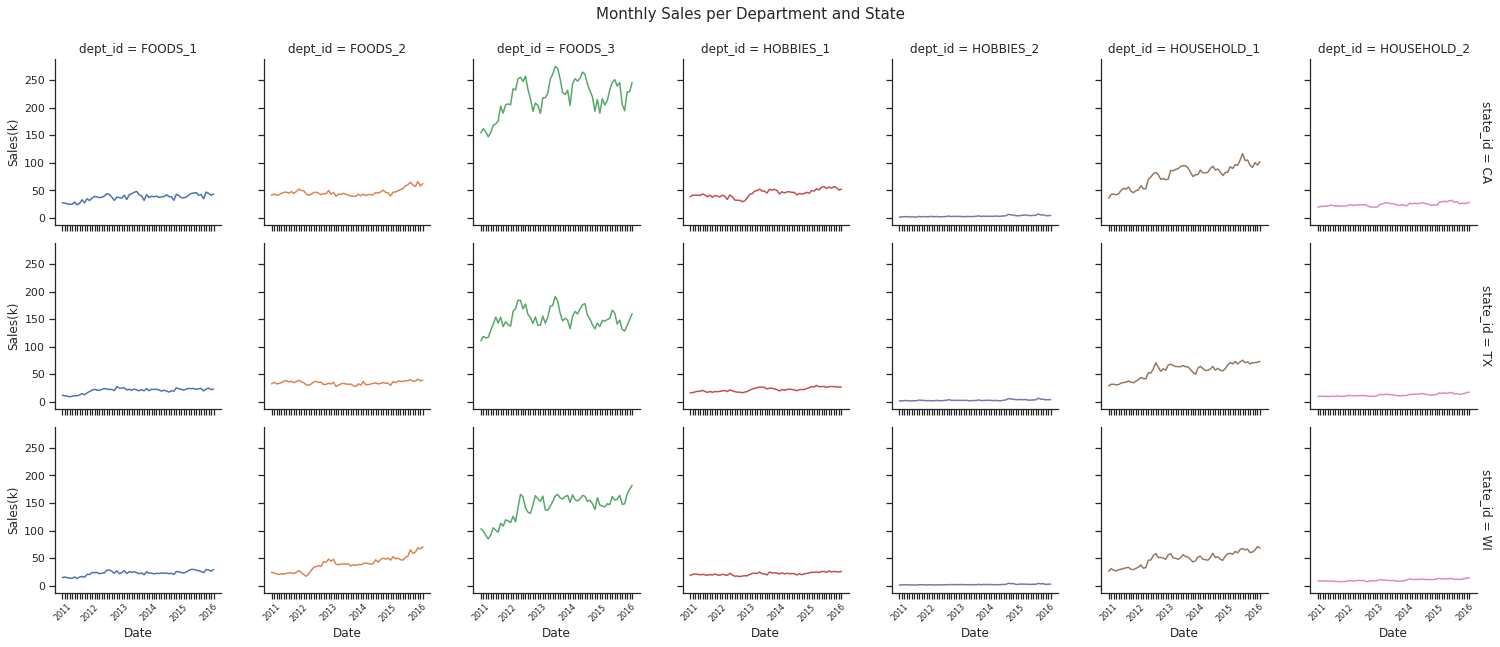

In [ ]:
#@title
df_cat_store = df.groupby(['dept_id','state_id']).sum().T
df_cat_store['ym'] = df_cat_store.index.map(lambda x: str(x)[:7])
df_cat_store = df_cat_store.groupby('ym').sum().iloc[1:63,:]/1000
data=pd.DataFrame(df_cat_store.T.to_records()).melt(id_vars=['dept_id','state_id'],var_name='ym')
g = sns.FacetGrid(data, col="dept_id", row="state_id", margin_titles=True,hue = 'dept_id')
g.map_dataframe(sns.lineplot, x="ym", y="value")
for ax in g.axes.flat:
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales(k)')
    ax.set_xticklabels(xticks,fontsize=8, rotation=45)
g.fig.subplots_adjust(top=0.9) 
g.fig.suptitle('Monthly Sales per Department and State',size=15)

**Findings:**
1. Clearly, 'FOODS_3' is driving the majority of 'FOODS' category sales in all states. In WI, 'FOODS_2' is picking up gradually towards the end of the time range.
2. Similarly, 'HOUSEHOLD_1'/'HOBBIES_1' is clearly outselling 'HOUSEHOLD_2'/'HOBBIES_2'. Both the two 'HOBBIES' categories don't show much development over the time.

## 3.3 Seasonality Analysis

### 3.3.1 Total Sales with Smooth Fit and Seasonality

Because of the general increasing trend in sales, we’re not looking at absolute sales values. Instead, we aim to model this trend using a smoothed (LOESS) fit which we then subtract from the data. I moved rge Christmas dips to avoid distraction in the model.

In [ ]:
#@title
bar = df[[i for i in df.columns if str(i)[4:]!='-12-25']].sum()[6:1914]
lowess_model = lowess.Lowess()
lowess_model.fit(np.array(range(1908)), bar.values.astype('float64'))
fig = px.line(x=bar.index,y=lowess_model.predict(np.array(range(1908))),color_discrete_sequence=["blue"],labels={'x':'Date','y':'Sales(k)'})
fig.add_scatter(x=bar.index,y=bar.values, mode='lines',line={'color':'lightblue'})
fig.update_layout(showlegend=False,title='Aggregated Whole Sales with Smoothing Fit')

### 3.3.2 Sales per State with Smooth Fit and Seasonality

Text(0.5, 0.98, 'Sales per State with Smoothing Fit')

<Figure size 1296x360 with 0 Axes>

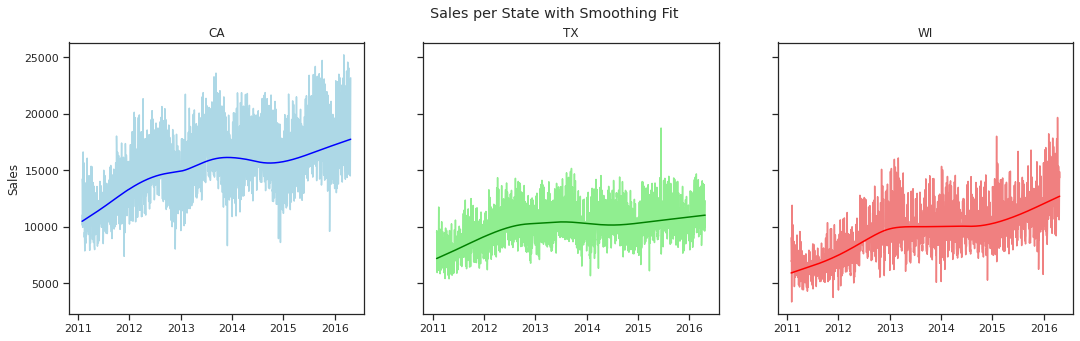

In [ ]:
#@title
bar_store = df[[i for i in df.columns if str(i)[4:]!='-12-25']].groupby('state_id').sum()
fig=plt.figure(figsize=(18,5))
fig, axs = plt.subplots(1,3,figsize=(18,5),sharey=True)
axs[0].plot(bar_store.loc['CA',:],color='lightblue')
axs[0].set_ylabel('Sales')
axs[0].set_title('CA')
lowess_model_CA = lowess.Lowess()
lowess_model_CA.fit(np.array(range(1908)), bar_store.loc['CA',:].values)
axs[0].plot(bar_store.columns, lowess_model_CA.predict(np.array(range(1908))),color='blue')
axs[1].plot(bar_store.loc['TX',:],color='lightgreen')
lowess_model_TX = lowess.Lowess()
lowess_model_TX.fit(np.array(range(1908)), bar_store.loc['TX',:].values)
axs[1].plot(bar_store.columns, lowess_model_TX.predict(np.array(range(1908))),color='green')
axs[1].set_title('TX')
axs[2].plot(bar_store.loc['WI',:],color='lightcoral')
lowess_model_WI = lowess.Lowess()
lowess_model_WI.fit(np.array(range(1908)), bar_store.loc['WI',:].values)
axs[2].plot(bar_store.columns, lowess_model_WI.predict(np.array(range(1908))),color='red')
axs[2].set_title('WI')
fig.suptitle('Sales per State with Smoothing Fit')

### 3.3.3 Seasonality in Fitting Residuals

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.add is deprecated. In a future version, a TypeError will be raised. Before calling .add, select only columns which should be valid for the function.



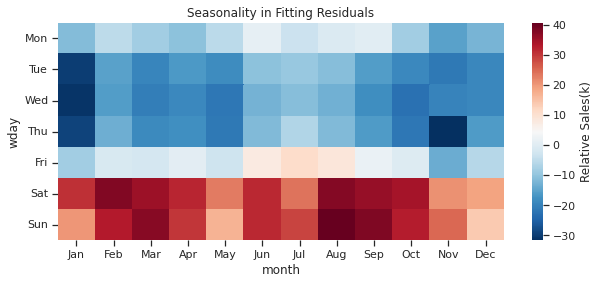

In [ ]:
#@title
p2 = pd.DataFrame({'residual':(bar.values-lowess_model.predict(np.array(range(1908))))/1000,
                   'date':bar.index})
p2['wday'] = p2['date'].apply(lambda x: x.weekday())
p2['month'] = p2['date'].apply(lambda x: x.month)
p2['year'] = p2['date'].apply(lambda x: x.year)
p3 = p2.groupby(['wday','month','year']).sum().reset_index().groupby(['wday','month']).mean().reset_index()
plt.subplots(figsize=(10,4))
g = sns.heatmap(p3.pivot(index='wday',columns='month',values='residual'),cmap="RdBu_r",cbar_kws={'label': 'Relative Sales(k)'})
g.set_yticklabels(("Mon","Tue","Wed","Thu","Fri","Sat","Sun"),rotation=360)
g.set_xticklabels(("Jan","Feb","Mar","Apr","May","Jun","Jul",'Aug','Sep','Oct','Nov','Dec'))
plt.title('Seasonality in Fitting Residuals')
plt.show()

**Findings:**
1. Weekly pattern is strong, with Saturdays and Sundays standing out prominently. Fri and Mon seem to benefit from the weekend effect.
2. Nov, Dec and Jan show clear dips and summer months May, Jun and Jul show a milder dip.

### 3.3.4 Weekly&Monthly Seasonality in Residuals per State and Breakdown by **Category**

Next, we’ll look at the weekly and monthly patterns on a state level with the similar smoothing method mentioned above. Besides, I'll further make a breakdown by category.

In [ ]:
#@title
bar_store_cat = df[[i for i in df.columns if str(i)[4:]!='-12-25']].groupby(['cat_id','state_id']).sum()
bar_store_cat_T = bar_store_cat.T
bar_store_cat_T = bar_store_cat.T.copy()
for j in ['CA','TX','WI']:
  for i in ['FOODS','HOBBIES','HOUSEHOLD']:
    lowess_model = lowess.Lowess()
    lowess_model.fit(np.array(range(1908)), bar_store_cat_T.loc[:,i].loc[:,j].values)
    bar_store_cat_T.loc[:,(i,j)] = (bar_store_cat_T.loc[:,i].loc[:,j] - lowess_model.predict(np.array(range(1908))))
    bar_store_cat_T.loc[:,(i,j)] = bar_store_cat_T.loc[:,(i,j)]/bar_store_cat.T.loc[:,(i,j)].mean()
bar_store_cat_T['wday'] = pd.Series(bar_store_cat_T.index).apply(lambda x: x.weekday()).values
bar_store_cat_T['month'] = pd.Series(bar_store_cat_T.index).apply(lambda x: x.month).values

In [ ]:
#@title
bar_store_T = bar_store.T
bar_store_T['CA'] = (bar_store_T['CA'] - lowess_model_CA.predict(np.array(range(1908))))/1000
bar_store_T['TX'] = (bar_store_T['TX'] - lowess_model_TX.predict(np.array(range(1908))))/1000
bar_store_T['WI'] = (bar_store_T['WI'] - lowess_model_WI.predict(np.array(range(1908))))/1000
bar_store_T['wday'] = bar_store_T.reset_index()['index'].apply(lambda x: x.weekday()).values
wday = bar_store_T.groupby('wday').sum()
wday['CA'] = wday['CA']/(bar_store.loc['CA',:].mean()/1000)
wday['TX'] = wday['TX']/(bar_store.loc['TX',:].mean()/1000)
wday['WI'] = wday['WI']/(bar_store.loc['WI',:].mean()/1000)
bar_store_T['month'] = bar_store_T.reset_index()['index'].apply(lambda x: x.month).values
month = bar_store_T.groupby('month').sum()
month['CA'] = month['CA']/(bar_store.loc['CA',:].mean()/1000)
month['TX'] = month['TX']/(bar_store.loc['TX',:].mean()/1000)
month['WI'] = month['WI']/(bar_store.loc['WI',:].mean()/1000)

<Figure size 1296x360 with 0 Axes>

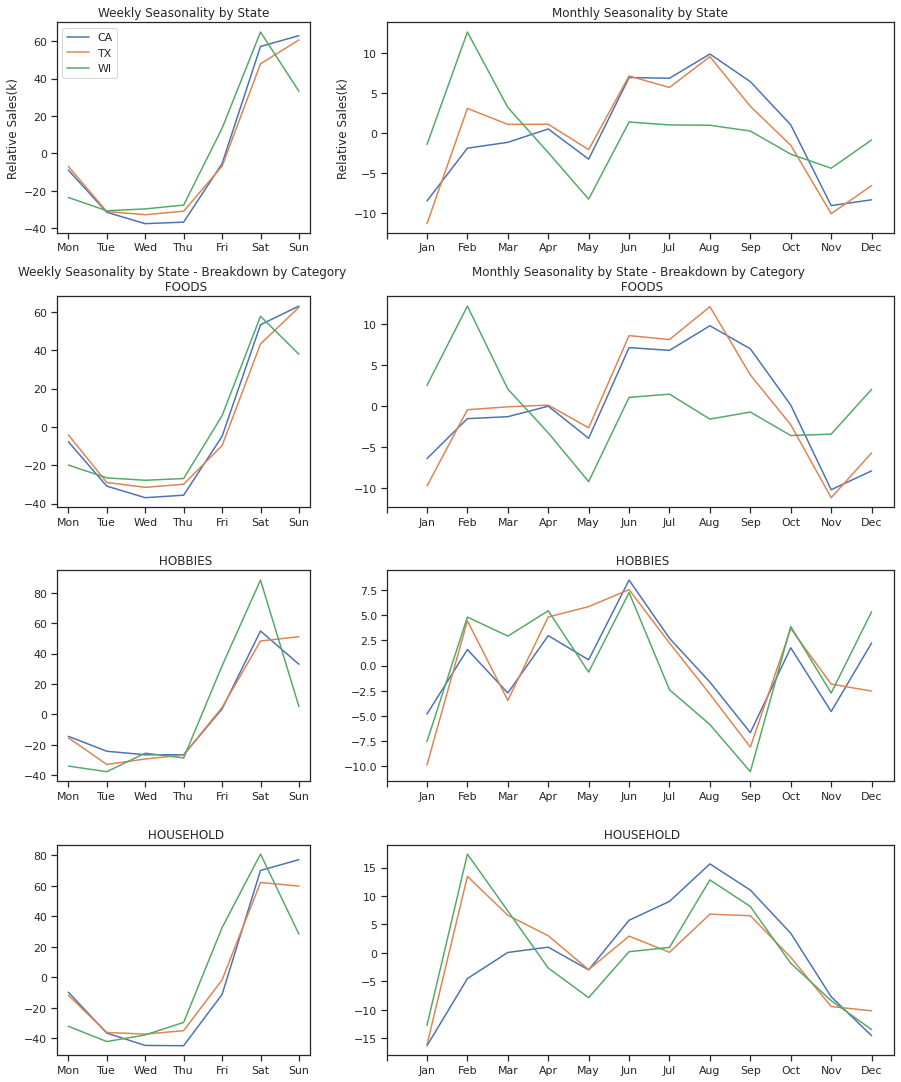

In [ ]:
#@title
fig=plt.figure(figsize=(18,5))
fig, axs = plt.subplots(4,2,figsize=(15,19),gridspec_kw={'width_ratios': [2,4]})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["b", "r", "g"]) 
cat = ['FOODS','HOBBIES','HOUSEHOLD']
dt = ['wday','month']
tt = ['Weekly','Monthly']
xtl = [['',"Mon","Tue","Wed","Thu","Fri","Sat","Sun"],['',"Jan","Feb","Mar","Apr","May","Jun","Jul",'Aug','Sep','Oct','Nov','Dec']]
axs[0,0].plot(wday)
axs[0,0].set_xticklabels(xtl[0])
axs[0,0].set_ylabel('Relative Sales(k)')
axs[0,0].set_title('Weekly Seasonality by State')
axs[0,0].legend(['CA','TX','WI'])
axs[0,1].plot(month[['CA','TX','WI']])
axs[0,1].set_xticks(range(13))
axs[0,1].set_xticklabels(xtl[1])
axs[0,1].set_ylabel('Relative Sales(k)')
axs[0,1].set_title('Monthly Seasonality by State')
for i in range(1,4):
  for j in [0,1]:
    axs[i,j].plot(bar_store_cat_T.groupby(dt[j]).sum()[cat[i-1]])
    if i == 1:
      axs[i,j].set_title(tt[j]+' Seasonality by State - Breakdown by Category \n FOODS')
    else:
      axs[i,j].set_title('\n '+ cat[i-1])
    if j == 1:
      axs[i,j].set_xticks(range(13))
    axs[i,j].set_xticklabels(xtl[j])
plt.subplots_adjust(hspace=0.3)

**Findings:**
1. The weekly patterns for the 'FOODS' category are very similar for all the 3 states. 'HOBBIES' and 'HOUSEHOLD' show deviations in WI, and WI experiences a dip on Sunday for all the 3 categories.
2. Monthly patterns: for 'FOODS', CA and TX have similar patterns while WI shows an invernted pattern when it comes to summer and winter. For 'HOBBIES', the 3 states show similar patterns with July-September dip. For 'HOUSEHOLD', CA doesn't sell as much as the other 2 states during the first 3 months but slightly more in the summer.

## 3.4 Explanatory Variables: Prices and Calendar

### 3.4.1 Calendar

#### 3.4.1.1 Events

In [ ]:
we = calendar[~calendar['event_name_1'].isna()]
# % of Days with Events
print('{:.2%} of Days Are with Events'.format(we.shape[0]/calendar.shape[0]))

8.23% of Days Are with Events


Text(0.5, 0, '% among all types of events')

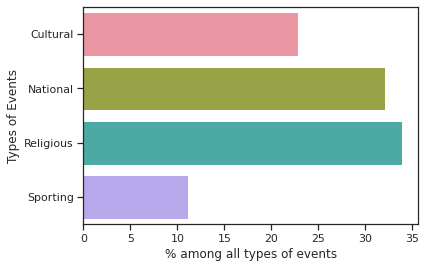

In [ ]:
#@title
sns.barplot(y='event_type_1',x='event_name_1',
            data=pd.DataFrame(we.groupby('event_type_1').count()['event_name_1']*100/we.shape[0]).reset_index())
plt.ylabel('Types of Events')
plt.xlabel('% among all types of events')

**Findings:**
1. In the period we look into, about 8% of days have a special events, around 1/3 are Religious(e.g. Orthodox Easter), 1/3 are National Holidays(e.g. Independence Day), 1/4 are Cultural(e.g. Halloween) and the rest are Sporting(e.g. Super Bowl). These events may affect the unit sales in stores

#### 3.4.1.2  SNAP Purchase

SNAP   dewdf efgrteghr

In [ ]:
print('% of Days with SNAP purchase allowed in each state: \n',
      'CA: {:.2%} \n'.format(calendar['snap_CA'].mean()),
      'TX: {:.2%} \n'.format(calendar['snap_TX'].mean()),
      'WI: {:.2%} \n'.format(calendar['snap_WI'].mean()))

% of Days with SNAP purchase allowed in each state: 
 CA: 33.01% 
 TX: 33.01% 
 WI: 33.01% 



**Findings:**
1. Percentage of days allowing SNAP food purchases among the days we observe is around 33% in each state.
2. 

### 3.4.2 Item Price

In [ ]:
#@title
prices['state_id'] = prices['store_id'].apply(lambda x:x[:2])
prices['cat_id'] = prices['item_id'].apply(lambda x: x.split('_')[0])
prices['dept_id'] = prices['item_id'].apply(lambda x: x.split('_')[1])
prices['sell_price'] = prices['sell_price'].apply(lambda x: math.log10(x))
prices['year'] = prices['wm_yr_wk'].apply(lambda x: 2000+int(str(x)[1:3]))

Text(0.5, 0.98, 'Item Prices Varies by State and Category')

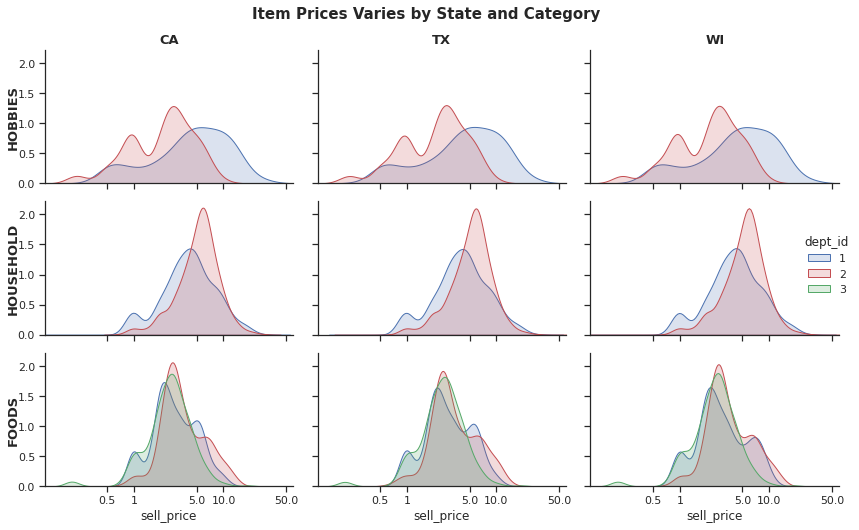

In [ ]:
#@title
g = sns.FacetGrid(data=prices[['sell_price','state_id','cat_id','dept_id']], col='state_id', row='cat_id', hue='dept_id',height=2.5,aspect=1.5)
g.map(sns.kdeplot,'sell_price', bw_method=0.3, alpha=0.2, fill=True)
g.set(xlim=(math.log10(.1),math.log10(60)))
ticks = [math.log10(0.5),0,math.log10(5),1, math.log10(50)]
labels = [0.5,1,5.0,10.0,50.0]
g.set(xticks = ticks, xticklabels = labels)
g.set_titles('')
for ax,s in zip(g.axes[0,:],['CA','TX','WI']):
    ax.set_title(s, fontweight='bold', fontsize=13)
for ax,c in zip(g.axes[:,0],['HOBBIES','HOUSEHOLD','FOODS']):
    ax.set_ylabel(c, fontweight='bold', fontsize=13, rotation=90, ha='center', va='center')
g.add_legend()
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9) 
g.fig.suptitle('Item Prices Varies by State and Category',fontweight='bold', fontsize=15)

**Findings:**
1. State-wise, The distributions of the three categories in the three states are nearly identical. While 'FOODS' category has noticable difference, it can be caused due to bandwidth, in practice, we can consider those distributions are the same.
2. Category-wise, 'HOUSEHOLD' items are more expensive than 'FOODS' items on average. And 'HOBBIES' category has two peaks and spans a wider range of prices than the other two.
3. Within one category, we can see noticable differences among departments. 
   *   Within 'HOBBIES' category, both departments have pretty broad distributions. Look closely, 'HOBBIES_1' accounts for almost all of the items above $10 and 'HOBBIES_2' has a bimodal structure.  
   *   Within 'FOODS' category, 'FOODS_3' doesn't have a heavy high-price tail as the other 2 departments.
   *   Within 'HOUSEHOLD' category, clearly, 'HOUSEHOLD_2' peaks at higher prices than 'HOUSEHOLD_1'.

Text(0.5, 0.98, 'Item Prices Varies by Category and Year')

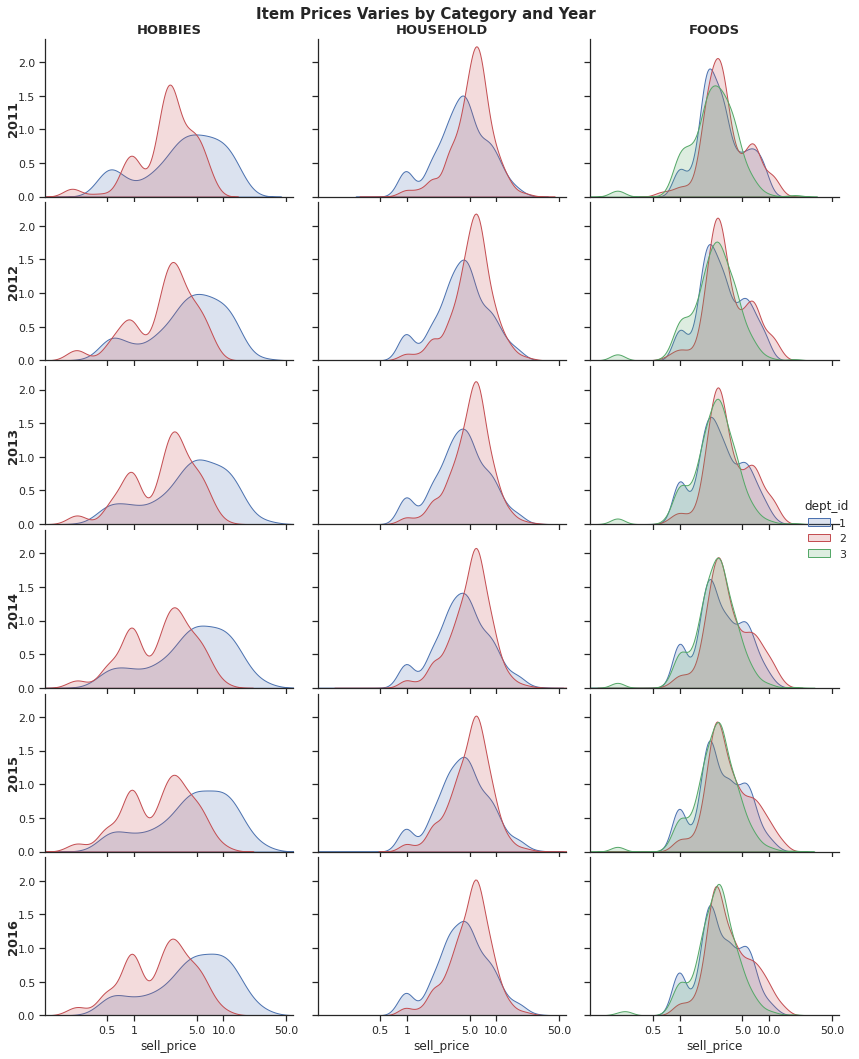

In [ ]:
#@title
g = sns.FacetGrid(data=prices[['sell_price','year','cat_id','dept_id']], col='cat_id', row='year', hue='dept_id',height=2.5,sharey=True,aspect=1.5)
g.map(sns.kdeplot,'sell_price', bw_method=0.3, alpha=0.2, fill=True)
g.set(xlim=(math.log10(.1),math.log10(60)))
ticks = [math.log10(0.5),0,math.log10(5),1, math.log10(50)]
labels = [0.5,1,5.0,10.0,50.0]
g.set(xticks = ticks, xticklabels = labels)
g.set_titles('')
for ax,s in zip(g.axes[0,:],['HOBBIES','HOUSEHOLD','FOODS']):
    ax.set_title(s, fontweight='bold', fontsize=13)
for ax,c in zip(g.axes[:,0],['2011','2012','2013','2014','2015','2016']):
    ax.set_ylabel(c, fontweight='bold', fontsize=13, rotation=90, ha='center', va='center')
g.add_legend()
g.fig.tight_layout(h_pad=0)
g.fig.subplots_adjust(top=0.95) 
g.fig.suptitle('Item Prices Varies by Category and Year',fontweight='bold', fontsize=15)

**Findings:**
1. dwe

### 3.4.3  Link to time series data

#### 3.4.3.1 Category Level

In [ ]:
#@title
cat = train.groupby('cat_id').sum()
start_dt = datetime.strptime('2011-01-29','%Y-%m-%d')
cat.columns = [str((start_dt+timedelta(days=int(i[2:])-1)).date()) if i[:2]=='d_' else i for i in cat.columns]
cat = cat[[i for i in cat.columns if str(i)[4:]!='-12-25']]
cat = cat.T.reset_index().merge(calendar[['date','event_name_1','event_type_1']],how='left',left_on='index',right_on='date')
cat['event'] = cat['event_name_1'].apply(lambda x: False if pd.isna(x) else True)
cat['FOODS'] = cat['FOODS']/1000
cat['HOBBIES'] = cat['HOBBIES']/1000
cat['HOUSEHOLD'] = cat['HOUSEHOLD']/1000

In [ ]:
#@title
cat_lst = ['FOODS','HOBBIES','HOUSEHOLD']
def lowess_sep(cat_lst,cat):
  for i in range(3):
    cat[cat_lst[i]+'_loess'] = cat[cat_lst[i]]
    lowess_model = lowess.Lowess()
    lowess_model.fit(np.array(range(len(cat[cat['event']==True]))), cat[cat['event']==True].iloc[:,1+i].values)
    cat.iloc[cat[cat['event']==True].index,8+i*2] = lowess_model.predict(np.array(range(len(cat[cat['event']==True]))))
    lowess_model = lowess.Lowess()
    lowess_model.fit(np.array(range(len(cat[cat['event']==False]))), cat[cat['event']==False].iloc[:,1+i].values)
    cat.iloc[cat[cat['event']==False].index,8+i*2] = lowess_model.predict(np.array(range(len(cat[cat['event']==False]))))
    lowess_model = lowess.Lowess()
    lowess_model.fit(np.array(range(len(cat))), cat.iloc[:,1+i].values,frac=1/2)
    cat[cat_lst[i]+'_loess_all'] = lowess_model.predict(np.array(range(len(cat))))
lowess_sep(cat_lst,cat)

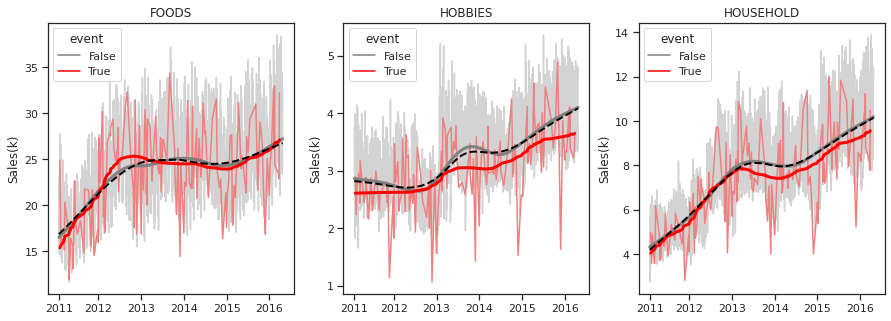

In [ ]:
#@title
fig, axs = plt.subplots(1,3,figsize=(15,5))
for i in range(3):
  sns.lineplot(ax=axs[i],data=cat, x='index', y=cat_lst[i], hue='event', palette=['lightgrey','lightcoral'],legend=False)
  sns.lineplot(ax=axs[i],data=cat, x='index', y=cat_lst[i]+'_loess', hue='event', palette=['grey','red'],legend=True, linewidth=3)
  sns.lineplot(ax=axs[i],data=cat, x='index', y=cat_lst[i]+'_loess_all', color='black', legend=False,linewidth=2,linestyle='--')
  axs[i].set_xticks([0,336,701,1065,1429,1793])
  axs[i].set_xticklabels([2011,2012,2013,2014,2015,2016])
  axs[i].set_ylabel('Sales(k)')
  axs[i].set_xlabel(None)
  axs[i].set_title(cat_lst[i])

**Findings:**
1. 
2. 

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



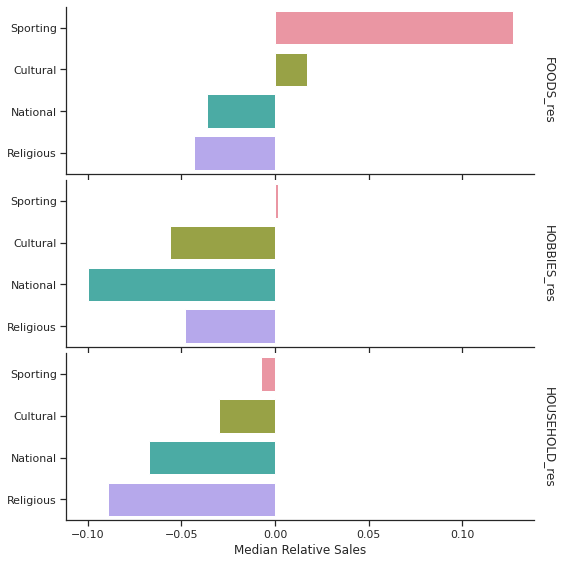

In [ ]:
#@title
cat_event = cat[-cat['event_name_1'].isna()]
cat_event.loc[:,'FOODS_res'] = (cat_event['FOODS'] - cat_event['FOODS_loess_all'])/np.mean(cat_event['FOODS'])
cat_event.loc[:,'HOBBIES_res'] = (cat_event['HOBBIES'] - cat_event['HOBBIES_loess_all'])/np.mean(cat_event['HOBBIES'])
cat_event.loc[:,'HOUSEHOLD_res'] = (cat_event['HOUSEHOLD'] - cat_event['HOUSEHOLD_loess_all'])/np.mean(cat_event['HOUSEHOLD'])
g = sns.catplot(
    data=cat_event[['FOODS_res','HOBBIES_res','HOUSEHOLD_res','event_type_1']].melt(id_vars=['event_type_1']), 
    x="value", y="event_type_1", row="variable",
    kind="bar", orient="h", ci=None,estimator=np.median,
    sharex=True, margin_titles=True, aspect=4
)
g.fig.set_size_inches(8,8)
g.set(xlabel="Median Relative Sales", ylabel="")
g.fig.tight_layout(h_pad=0)
g.set_titles(row_template="{row_name}")

**Findings:**
1. 
2. 

#### 3.4.3.2 State Level

In [ ]:
#@title
state = train.groupby('state_id').sum()
start_dt = datetime.strptime('2011-01-29','%Y-%m-%d')
state.columns = [str((start_dt+timedelta(days=int(i[2:])-1)).date()) if i[:2]=='d_' else i for i in state.columns]
state = state[[i for i in state.columns if str(i)[4:]!='-12-25']]
state = state.T.reset_index().merge(calendar[['date','event_name_1','event_type_1']],how='left',left_on='index',right_on='date')
state['event'] = state['event_name_1'].apply(lambda x: False if pd.isna(x) else True)
state['CA'] = state['CA']/1000
state['TX'] = state['TX']/1000
state['WI'] = state['WI']/1000
state_lst = ['CA','TX','WI']
lowess_sep(state_lst, state)

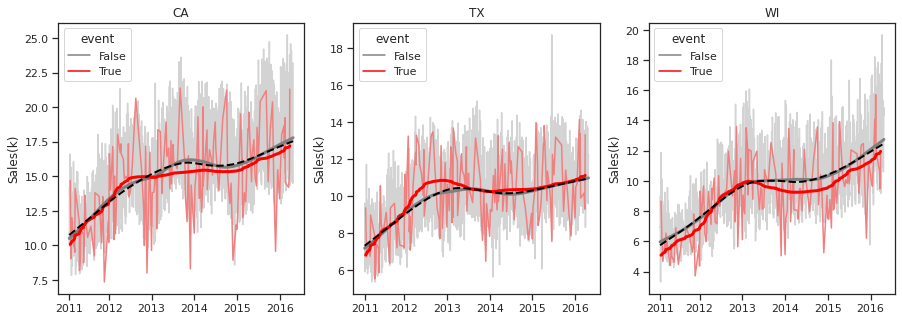

In [ ]:
#@title
fig, axs = plt.subplots(1,3,figsize=(15,5))
for i in range(3):
  sns.lineplot(ax=axs[i],data=state, x='index', y=state_lst[i], hue='event', palette=['lightgrey','lightcoral'],legend=False)
  sns.lineplot(ax=axs[i],data=state, x='index', y=state_lst[i]+'_loess', hue='event', palette=['grey','red'],legend=True, linewidth=3)
  sns.lineplot(ax=axs[i],data=state, x='index', y=state_lst[i]+'_loess_all', color='black', legend=False,linewidth=2,linestyle='--')
  axs[i].set_xticks([0,336,701,1065,1429,1793])
  axs[i].set_xticklabels([2011,2012,2013,2014,2015,2016])
  axs[i].set_ylabel('Sales(k)')
  axs[i].set_xlabel(None)
  axs[i].set_title(state_lst[i])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



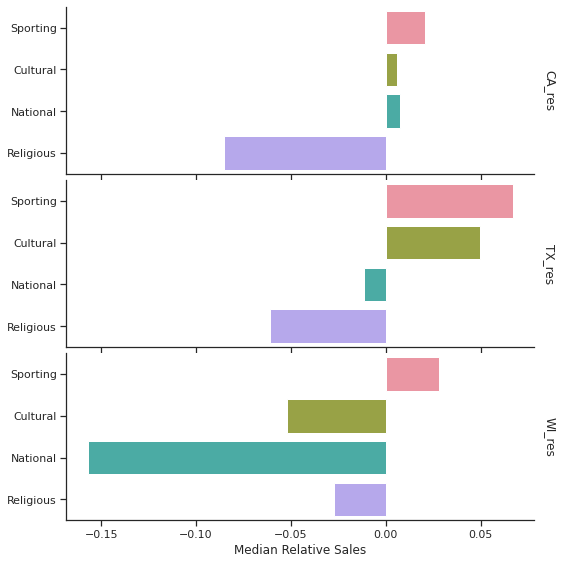

In [ ]:
#@title
state_event = state[-state['event_name_1'].isna()]
state_event.loc[:,'CA_res'] = (state_event['CA'] - state_event['CA_loess_all'])/np.mean(state_event['CA'])
state_event.loc[:,'TX_res'] = (state_event['TX'] - state_event['TX_loess_all'])/np.mean(state_event['TX'])
state_event.loc[:,'WI_res'] = (state_event['WI'] - state_event['WI_loess_all'])/np.mean(state_event['WI'])
g = sns.catplot(
    data=state_event[['CA_res','TX_res','WI_res','event_type_1']].melt(id_vars=['event_type_1']), 
    x="value", y="event_type_1", row="variable",
    kind="bar", orient="h", ci=None, estimator=np.median,
    sharex=True, margin_titles=True, aspect=4)
g.fig.set_size_inches(8,8)
g.set(xlabel="Median Relative Sales", ylabel="")
g.fig.tight_layout(h_pad=0)
g.set_titles(row_template="{row_name}")

In [ ]:
#@title
state = train.groupby('state_id').sum()
start_dt = datetime.strptime('2011-01-29','%Y-%m-%d')
state.columns = [str((start_dt+timedelta(days=int(i[2:])-1)).date()) if i[:2]=='d_' else i for i in state.columns]
state = state[[i for i in state.columns if str(i)[4:]!='-12-25']]
state = state.T.reset_index().merge(calendar[['date','snap_CA','snap_TX','snap_WI']],how='left',left_on='index',right_on='date')
state['CA'] = state['CA']/1000
state['TX'] = state['TX']/1000
state['WI'] = state['WI']/1000

In [ ]:
#@title
state_lst = ['CA','TX','WI']
for i in range(3):
    state[state_lst[i]+'_loess'] = state[state_lst[i]]
    lowess_model = lowess.Lowess()
    lowess_model.fit(np.array(range(len(state[state['snap_'+state_lst[i]]==1]))), state[state['snap_'+state_lst[i]]==1].iloc[:,1+i].values)
    state.iloc[state[state['snap_'+state_lst[i]]==1].index,8+i*2] = lowess_model.predict(np.array(range(len(state[state['snap_'+state_lst[i]]==1]))))
    lowess_model = lowess.Lowess()
    lowess_model.fit(np.array(range(len(state[state['snap_'+state_lst[i]]==0]))), state[state['snap_'+state_lst[i]]==0].iloc[:,1+i].values)
    state.iloc[state[state['snap_'+state_lst[i]]==0].index,8+i*2] = lowess_model.predict(np.array(range(len(state[state['snap_'+state_lst[i]]==0]))))
    lowess_model = lowess.Lowess()
    lowess_model.fit(np.array(range(len(state))), state.iloc[:,1+i].values,frac=1/2)
    state[state_lst[i]+'_loess_all'] = lowess_model.predict(np.array(range(len(state))))

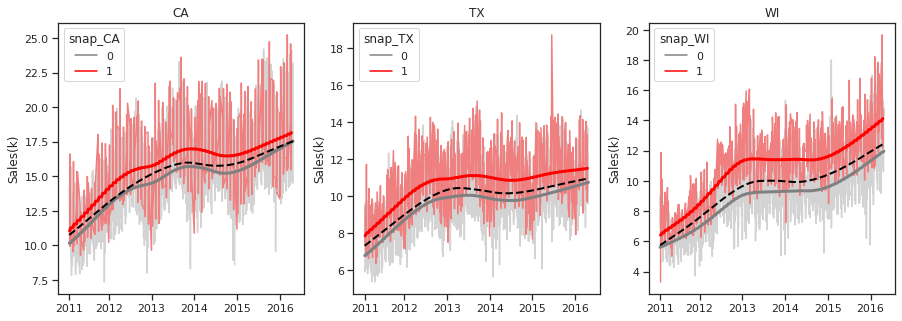

In [ ]:
#@title
fig, axs = plt.subplots(1,3,figsize=(15,5))
for i in range(3):
  sns.lineplot(ax=axs[i],data=state, x='index', y=state_lst[i], hue='snap_'+state_lst[i], palette=['lightgrey','lightcoral'],legend=False)
  sns.lineplot(ax=axs[i],data=state, x='index', y=state_lst[i]+'_loess', hue='snap_'+state_lst[i], palette=['grey','red'],legend=True, linewidth=3)
  sns.lineplot(ax=axs[i],data=state, x='index', y=state_lst[i]+'_loess_all', color='black', legend=False,linewidth=2,linestyle='--')
  axs[i].set_xticks([0,336,701,1065,1429,1793])
  axs[i].set_xticklabels([2011,2012,2013,2014,2015,2016])
  axs[i].set_ylabel('Sales(k)')
  axs[i].set_xlabel(None)
  axs[i].set_title(state_lst[i])

**Findings:**
1. 
2. 

In [ ]:
#@title
example_ids = ["FOODS_2_092_CA_1_validation", "HOUSEHOLD_2_071_TX_2_validation", "HOBBIES_1_348_WI_3_validation"]
example_sales = random_ts(train[train['id'].isin(example_ids)],False).drop(['item_id','dept_id','cat_id','store_id','cols'],axis=1).melt(['id','state_id'],var_name='date',value_name='sale')
example_sales['date'] = example_sales['date'].apply(lambda x:str(x))
example_prices = prices[(prices['item_id'] + '_' + prices['store_id'] + '_validation').isin(example_ids)]
example_prices['id'] = prices['item_id'] + '_' + prices['store_id']
example_calendar = calendar[['date','wm_yr_wk','event_name_1','snap_CA','snap_TX','snap_WI','d']].melt(['date','wm_yr_wk','event_name_1','d'],['snap_CA','snap_TX','snap_WI'],'state_id','snap')
example_calendar['state_id'] = example_calendar['state_id'].apply(lambda x:x[5:])
example = example_sales.merge(example_calendar,'left',['date','state_id']).merge(example_prices,'left',["id", "wm_yr_wk"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#@title
e1 = example[example['id']=='FOODS_2_092_CA_1']
e1 = e1[(e1['date'] >= "2015-05-01") & (e1['date'] <= "2015-10-01")].set_index('date')
e2 = example[example['id']=='HOUSEHOLD_2_071_TX_2']
e2 = e2[(e2['date'] >= "2015-05-01") & (e2['date'] <= "2015-10-01")].set_index('date')
e3 = example[example['id']=='HOBBIES_1_348_WI_3']
e3 = e3[(e3['date'] >= "2015-05-01") & (e3['date'] <= "2015-10-01")].set_index('date')
for e in [e1,e2,e3]:
  weekend_color_map = {1: 1, 0: 0}
  weekend_name_map = {1:"True", 0:"False"}
  e['color'] = e['snap'].map(weekend_color_map)
  e['name'] = e['snap'].map(weekend_name_map)
  ## use the color column since weekend corresponds to 0, nonweekend corresponds to 1
  first_weekend_idx = 1 #e1['color'].loc[e1['color'].idxmin()]
  first_nonweekend_idx = 152 #e1['color'].loc[e1['color'].idxmax()]
  e["showlegend"] = False
  showlegendIdx = e.columns.get_indexer(["showlegend"])[0]
  e.iat[first_weekend_idx, showlegendIdx] = True
  e.iat[first_nonweekend_idx, showlegendIdx] = True
  e["showlegend"] = e["showlegend"].astype(object)

In [ ]:
#@title
fig = make_subplots(rows=3, cols=1,subplot_titles=("FOODS_2_092_CA_1", "HOUSEHOLD_2_071_TX_2", "HOBBIES_1_348_WI_3"))
es=[e1,e2,e3]
for i in range(len(es)):
  fig.add_traces( 
    [go.Scatter(
            x=es[i].index[tn : tn + 2],
            y=es[i]['sale'][tn : tn + 2],
            mode='lines+markers',
            line_color=px.colors.qualitative.Plotly[es[i]['color'].values[tn]],
            name=es[i]['name'].values[tn],
            legendgroup=es[i]['name'].values[tn] if i ==0 else False,
            showlegend=es[i]['showlegend'].values[tn] if i ==0 else False
        )
      for tn in range(len(es[i]))],
      cols=[1]*len(es[i]),
      rows=[i+1]*len(es[i])
      )
  fig.add_trace(go.Scatter(x=es[i][-es[i]['event_name_1'].isna()].index,y=es[i][-es[i]['event_name_1'].isna()].sale.values,
                          mode='markers', name = 'Has Event' if i ==0 else '',
                         marker=dict(size=10,color='black')),row=i+1, col=1)
  fig.update_layout(title='Sales of 3 Random Items in Mid-2015',legend_title_text='Is SNAP Day')
fig.show()


Text(0.5, 0.98, 'Prices of 3 Random Items Change Over the Training Period')

<Figure size 720x360 with 0 Axes>

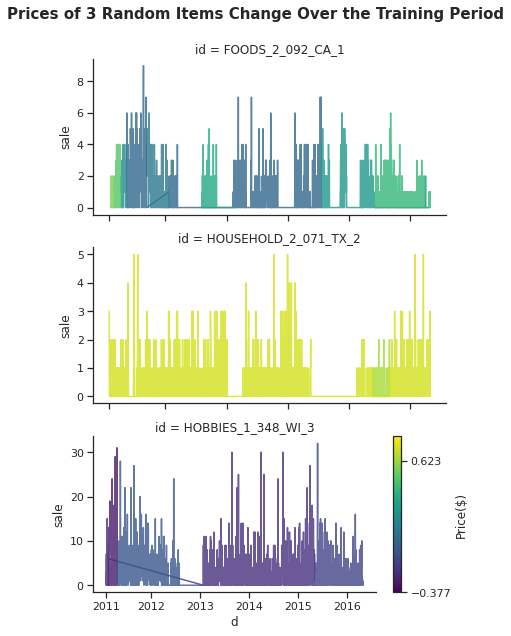

In [ ]:
#@title
import matplotlib as mpl

plt.figure(figsize=(10,5))
a1 = example[example['id'].isin(['HOBBIES_1_348_WI_3',"HOUSEHOLD_2_071_TX_2","FOODS_2_092_CA_1"])]
a1['d'] = a1['d'].apply(lambda x: int(x[2:]))
g = sns.FacetGrid(data= a1, 
                  row = 'id', 
                  hue = 'sell_price', 
                  palette = 'viridis', height=3, aspect=2, sharey=False)
g = g.map(sns.lineplot, 'd', 'sale', alpha = 0.8)
g.set(xticks=[0,336,701,1065,1429,1793])
g.set_xticklabels([2011,2012,2013,2014,2015,2016])
cmap = plt.get_cmap('viridis')
g.figure.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=a1['sell_price'].min(),
                                                                          vmax=a1['sell_price'].max(),
                                                                          clip=False),
                                        cmap=cmap),
                          ticks=np.arange(a1['sell_price'].min(), a1['sell_price'].max() + 1),
                          label='Price($)')
g.fig.subplots_adjust(top=0.9) 
g.fig.suptitle('Prices of 3 Random Items Change Over the Training Period',fontweight='bold', fontsize=15)

## 3.5 Zoom In: Individual Time Series with Explanatory Variables

##3.6 Summary Statistics

# 4. Feature Engineering

### 4.1 Melt and Merge data

In [ ]:
#@title
all = pd.read_csv('/content/drive/MyDrive/m5-forecasting-accuracy/sales_train_evaluation.csv')
#Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  
all = downcast(all)
prices = downcast(prices)
calendar = downcast(calendar)

In [ ]:
#@title
all = pd.melt(all, 
        id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
        var_name='d', 
        value_name='sold')
df = pd.merge(all, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 

## 4.2 Label Encoding

In [ ]:
df['d'] = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes
# Remove date as all of its information is already present.
df.drop('date',axis=1,inplace=True)

## 4.3 Introduce Lags

Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems. Lag features are target values(here I used **sold**) from previous periods. I got the lag from the last 1,2,3,7,15,30 days to capture signals.

In [ ]:
lags = [1,2,3,7,15,30]
for lag in lags:
  df['sold_'+str(lag)+'_ago'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sold'].shift(lag).astype(np.float16)

## 4.4 7D Rolling Average of Sales

A step beyond adding raw lagged values is to add a summary of the values at previous time steps. We can calculate summary statistics across the values in the sliding window and include these as features in our dataset. Perhaps the most useful is the mean of the previous few values, also called the rolling mean. (https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/)

In [ ]:
df['rolling7_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)

## 4.5 2D Expanding Window Average of Sales

Expanding Window includes all previous data and can help with keeping track of the bounds of observable data. 2 refers to the minimum number of observations in window required to have a value.



In [ ]:
df['expanding2_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)

## 4.7 Mean Encoding

In Mean Encoding we take the number of labels into account along with the target variable(here I used **sold**) to encode the labels into machine comprehensible values.

In [ ]:
df['item_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)
df['state_sold_avg'] = df.groupby('state_id')['sold'].transform('mean').astype(np.float16)
df['store_sold_avg'] = df.groupby('store_id')['sold'].transform('mean').astype(np.float16)
df['cat_sold_avg'] = df.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
df['dept_sold_avg'] = df.groupby('dept_id')['sold'].transform('mean').astype(np.float16)
df['cat_dept_sold_avg'] = df.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
df['store_item_sold_avg'] = df.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['store_state_sold_avg'] = df.groupby(['store_id','state_id'])['sold'].transform('mean').astype(np.float16)
df['cat_store_state_sold_avg'] = df.groupby(['cat_id','store_id','state_id'])['sold'].transform('mean').astype(np.float16)
df['dept_cat_store_sold_avg'] = df.groupby(['dept_id','cat_id','store_id'])['sold'].transform('mean').astype(np.float16)

## 4.6 Selling Trend

The feature I added is the difference between the sales of one item in a store in a day and the average sales of that item in that store within the entire periods.

In [ ]:
df['daily_avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sold'].transform('mean').astype(np.float16)
df['avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform('mean').astype(np.float16)
df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold']).astype(np.float16)
df.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)

## 4.7 Save the Data

In [ ]:
df[df['d']>=30].to_pickle('data.pkl')

# 5. Modeling & Evaluation

## 5.1 Build a LightGBM Model for Each Store

In [ ]:
all = pd.read_pickle('/content/drive/MyDrive/m5-forecasting-accuracy/data.pkl')

In [ ]:
store_code = train.store_id.astype('category').cat.codes.unique().tolist()
store_dict = dict(zip(train.store_id.astype('category').cat.codes, train.store_id))
for store in store_code:
  store_df = all[all['store_id']==store]
  # Split the data in to train, validation and test sets
  X_train, y_train = store_df[store_df['d']<1914].drop('sold',axis=1), store_df[store_df['d']<1914]['sold']
  X_valid, y_valid = store_df[(store_df['d']>=1914) & (store_df['d']<1942)].drop('sold',axis=1), store_df[(store_df['d']>=1914) & (store_df['d']<1942)]['sold']
  X_test = store_df[store_df['d']>=1942].drop('sold',axis=1)
  # Train and validate
  model = lgbm.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=8,
        num_leaves=50,
        min_child_weight=300
    )
  print('*****Prediction for Store: {}*****'.format(store_dict[store]))
  model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
            eval_metric='rmse', verbose=20, early_stopping_rounds=20)
  # valid_preds[X_valid.index] = model.predict(X_valid)
  # eval_preds[X_test.index] = model.predict(X_test)
  filename = 'model'+str(store_dict[store])+'.pkl'
  # save model
  joblib.dump(model, filename)
  del model, X_train, y_train, X_valid, y_valid
  gc.collect()
  

*****Prediction for Store: CA_1*****
Training until validation scores don't improve for 20 rounds.
[20]	training's rmse: 0.854958	training's l2: 0.730953	valid_1's rmse: 0.55127	valid_1's l2: 0.303899
[40]	training's rmse: 0.826568	training's l2: 0.683214	valid_1's rmse: 0.531572	valid_1's l2: 0.282569
[60]	training's rmse: 0.810617	training's l2: 0.657099	valid_1's rmse: 0.52861	valid_1's l2: 0.279429
[80]	training's rmse: 0.80089	training's l2: 0.641425	valid_1's rmse: 0.523395	valid_1's l2: 0.273942
[100]	training's rmse: 0.789507	training's l2: 0.623321	valid_1's rmse: 0.522134	valid_1's l2: 0.272624
[120]	training's rmse: 0.779613	training's l2: 0.607797	valid_1's rmse: 0.518645	valid_1's l2: 0.268993
[140]	training's rmse: 0.77272	training's l2: 0.597097	valid_1's rmse: 0.517915	valid_1's l2: 0.268236
Early stopping, best iteration is:
[130]	training's rmse: 0.775663	training's l2: 0.601653	valid_1's rmse: 0.517604	valid_1's l2: 0.267914
*****Prediction for Store: CA_2*****
Train

## 5.2 Feature Importantce

In [ ]:
store = []
features = []
importance = []
for filename in os.listdir('.'):
    if 'model' in filename:
        # load model
        model = joblib.load(filename)       
        features += [fi for fi in all.columns if fi != 'sold']
        importance += list(model.feature_importances_)
        store += [filename[5:9]] * (len(all.columns)-1)

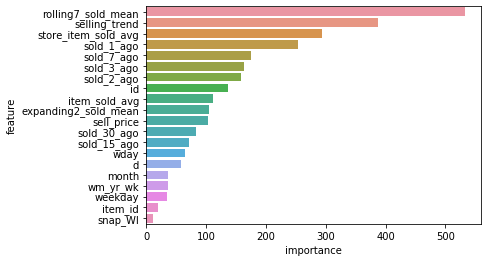

In [ ]:
fi_df = pd.DataFrame({'store':store,'feature':features,'importance':importance})
sns.barplot(x='importance',y='feature',data=fi_df.groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].reset_index())